<a href="https://colab.research.google.com/github/bodytaylor/dst_report/blob/main/Automate_Department_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ดึง Report จาก Opera cloud เพื่อนำไปทำ Department Revenue Report ประจำไตรมาศ

## Introduction

Pain point ที่ประสบพบเจอคือ
วิธีการที่ทำต่อๆ กันมา คือการ print report ออกมาเป็นกระดาษแล้วกรอกข้อมูลกลับลงไปใน excel เพื่อทำรายงานประจำไตรมาศ ขั้นตอนนี้กินเวลาประมาณครึ่งวัน หรืออาจมากกว่าถ้าเป็น High season 

ดังนั้นเราจะ Automate Tasks ทั้งหมดนี้

# Tasks list

1. Setup ให้ Opera Cloud ส่ง Department Report เข้ามาที่อีเมลล์รายเดือน
2. Download report จาก email attachment เก็บไว้ ที่ local
3. Cleaning report Data
4. Upload to Datalake
5. เมื่อสิ้นไตรมาศให้ สรุป ดึงข้อมูลจาก Data lake มาทำสรุปสวยๆ ส่ง

## 1. Setup ให้ Opera Cloud ส่ง Department Report เข้ามาที่อีเมลล์รายเดือน

เนื่องด้วย Operacloud จะดึงรีพอตได้สูงสุดครั้งละประมาณ 45 วันถ้าเราดองงานมาทำทีเดียววันสิ้นไตรมาศจะต้องเข้าไปดึงสามครั้ง เพราะฉะนั้นเราจะตั้งให้ระบบส่ง report เข้า email ทุกๆ สิ้นเดือน

ซึ่งตรงนี้สามารถ set ให้ส่งไปทาง sftp หรือว่าเข้าไป query โดยตรงกับ Database แล้วโหลดมาเก็บเลยก็ได้ แต่ว่าต้องใช้ user admin ในการตั้งค่าซึ่งเราไม่ใช่ 55555555
เลยต้องใช้วิธีกองโจรแบบนี้แทน

เราก็สร้าง email ใหม่มาอันนึงเพื่อรับ report นี้จะได้ไม่ต้องไปเขียนโค๊ดเพื่อ query email inbox อีกที

โดยเราจะโฟกัส email ที่เข้ามาล่าสุด ในเวลาที่กำหนดไว้

## 2. Download report จาก email attachment เก็บไว้ที่ local 


### เปิดใช้งาน APIs ของ google

แปะ Doc ของ Gmail API 
https://developers.google.com/gmail/api/quickstart/python


ก่อนอื่นให้สร้าง Project ขึ้นมาอันนึงแล้วเราก็สร้าง Google Cloud Store ใน GCP ก่อน ส่วน Setting เราก็เอาถูกๆ Server ที่ใกล้และถูกไว้ก่อน 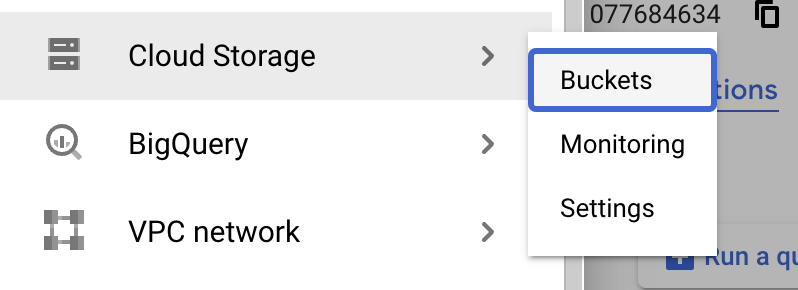


แล้วก็เข้าไปที่ APIs & Services เปิดใช้งาน API สองตัว
ตัวแรก Cloud Storage
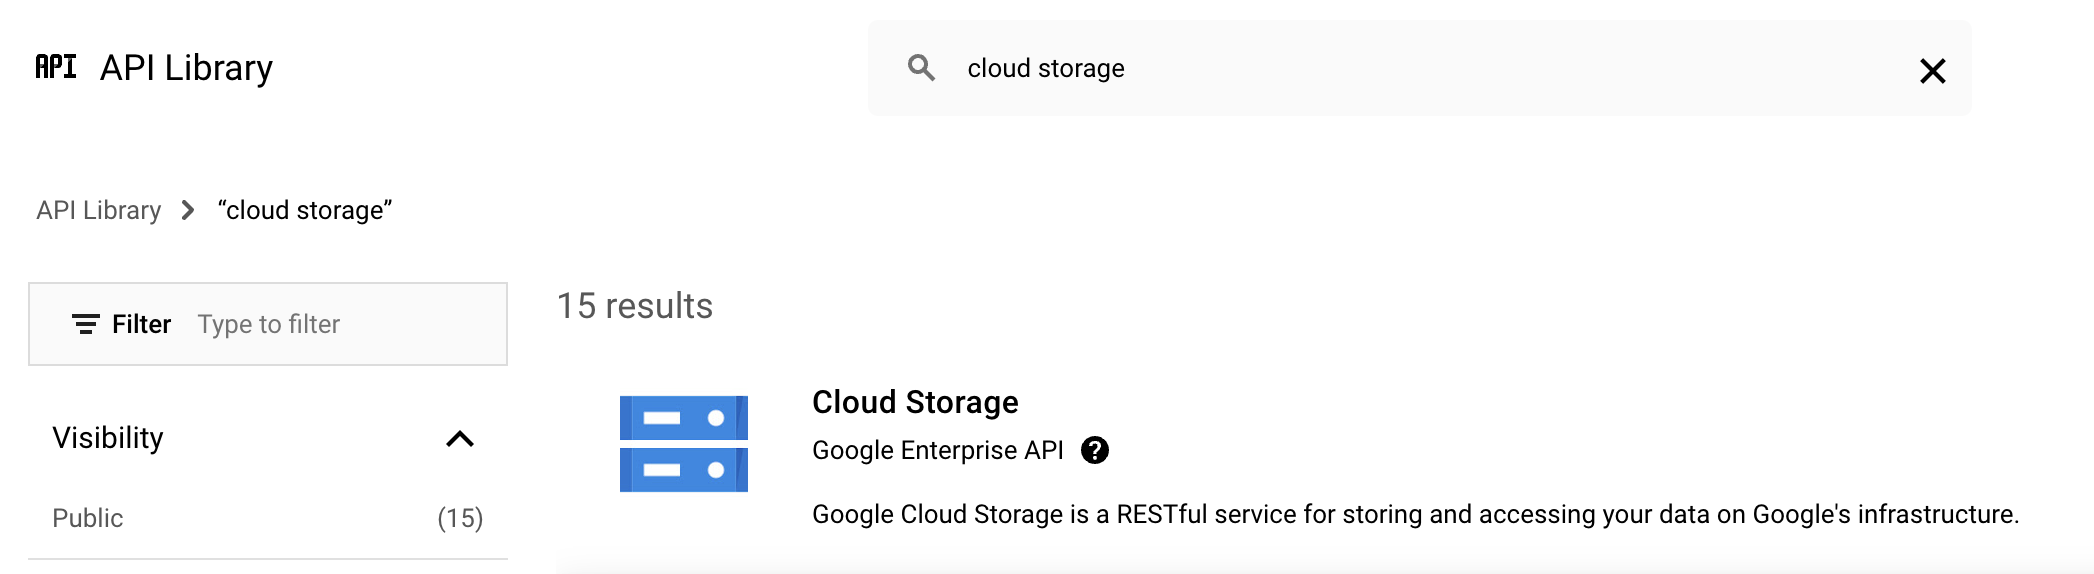
ตัวที่สอง Gmail
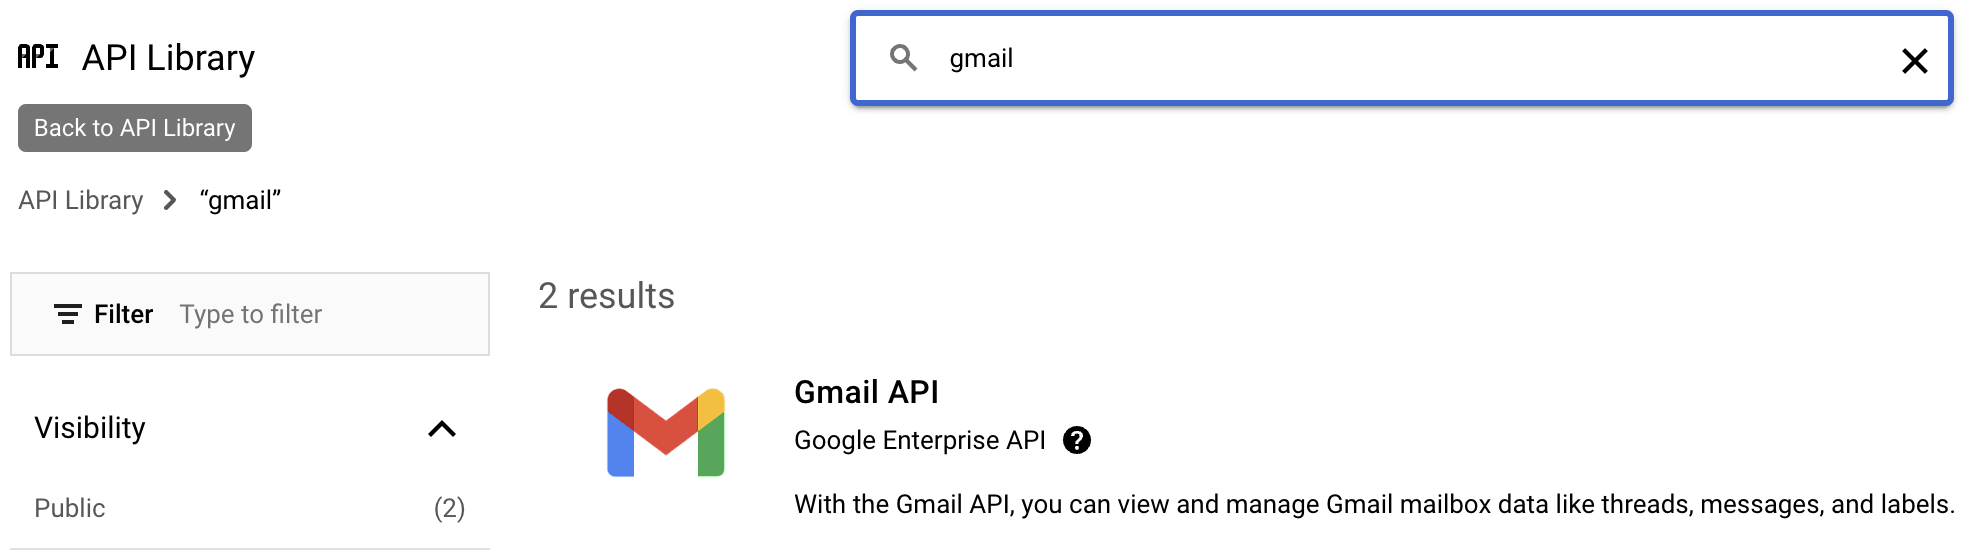

 import package ที่จำเป็นสำหรับการเชื่อมต่อกับ GCS

---



### เปิด OAuth consent screen

ตรงนี้จะเป็นการเปิดใช้งานหน้า User consent screen เพื่อ Signin และอนุญาติให้ API อ่านอีเมลล์ใน inbox ได้


โดยเข้าไปที่ APIs & Services >> OAuth consent screen
หน้าแรกกรอกแค่ App name, User support Email และ Developer Contact infomation หลังจากนั้นกด Save & continue ไปเรื่อยๆ 


แล้วเราก็กลับมาที่หน้า OAuth consent screen ตรงหัวข้อ Publishing status ให้เรากด publish ได้เลย


รอแปปนึงแอปเราก็จะขึ้นสถานะ In-production แบบนี้
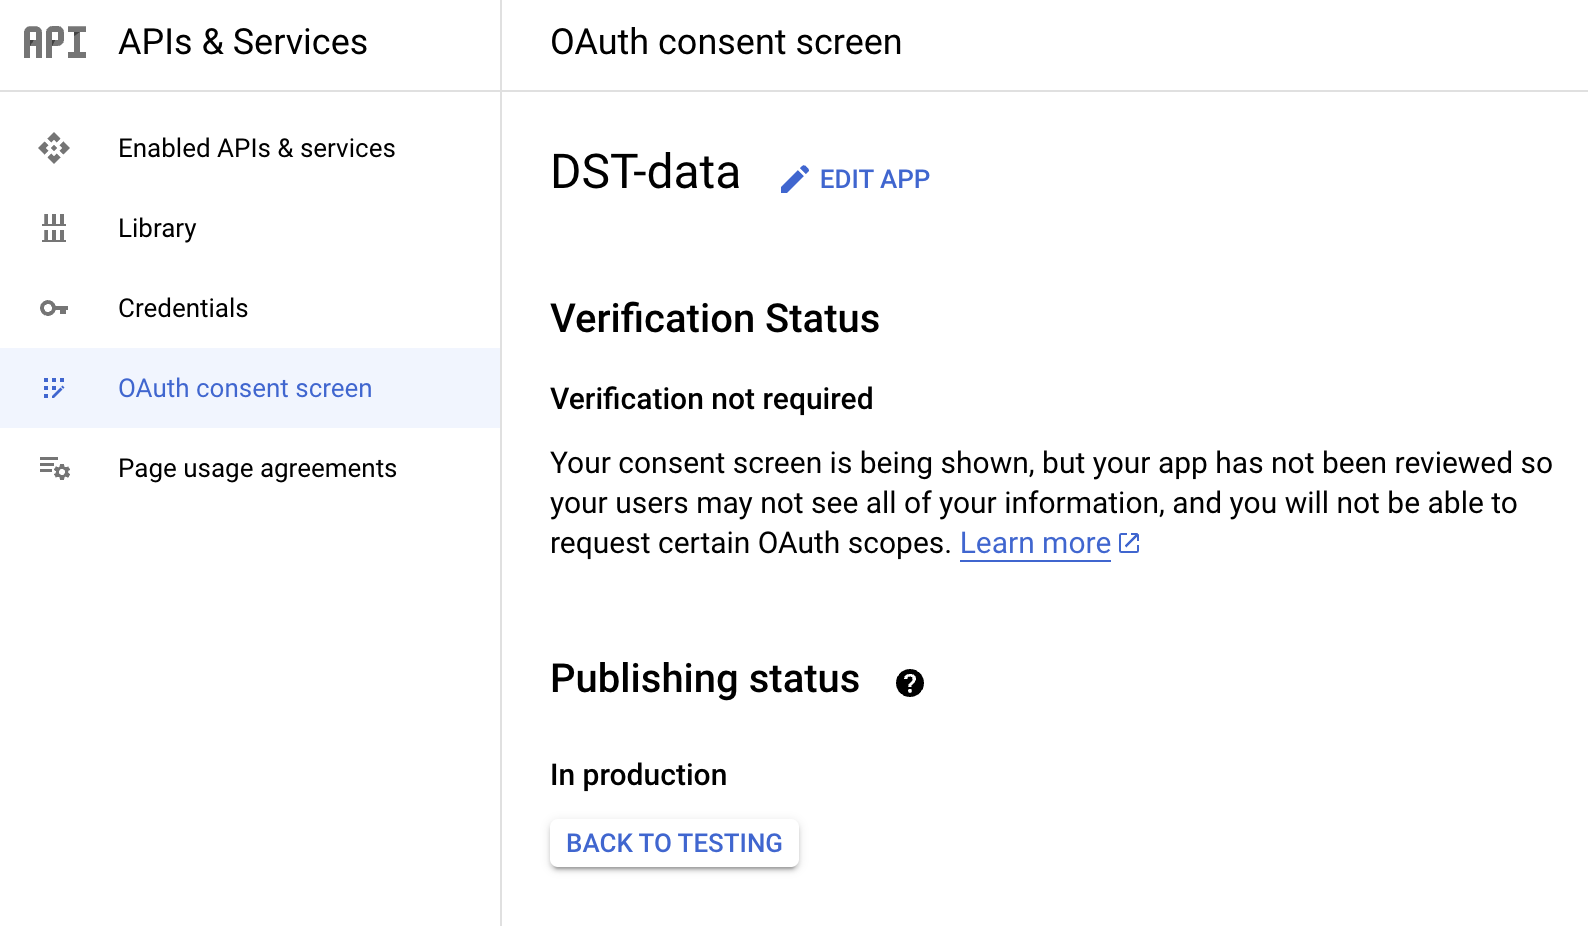

### สร้าง Credential ให้กับ User ที่ Sign-in

ไปที่หน้า APIs & Services >> Credentials แล้วจิ้ม Create Create Credential ตรงแทบด้านบน เลือก OAuth client ID

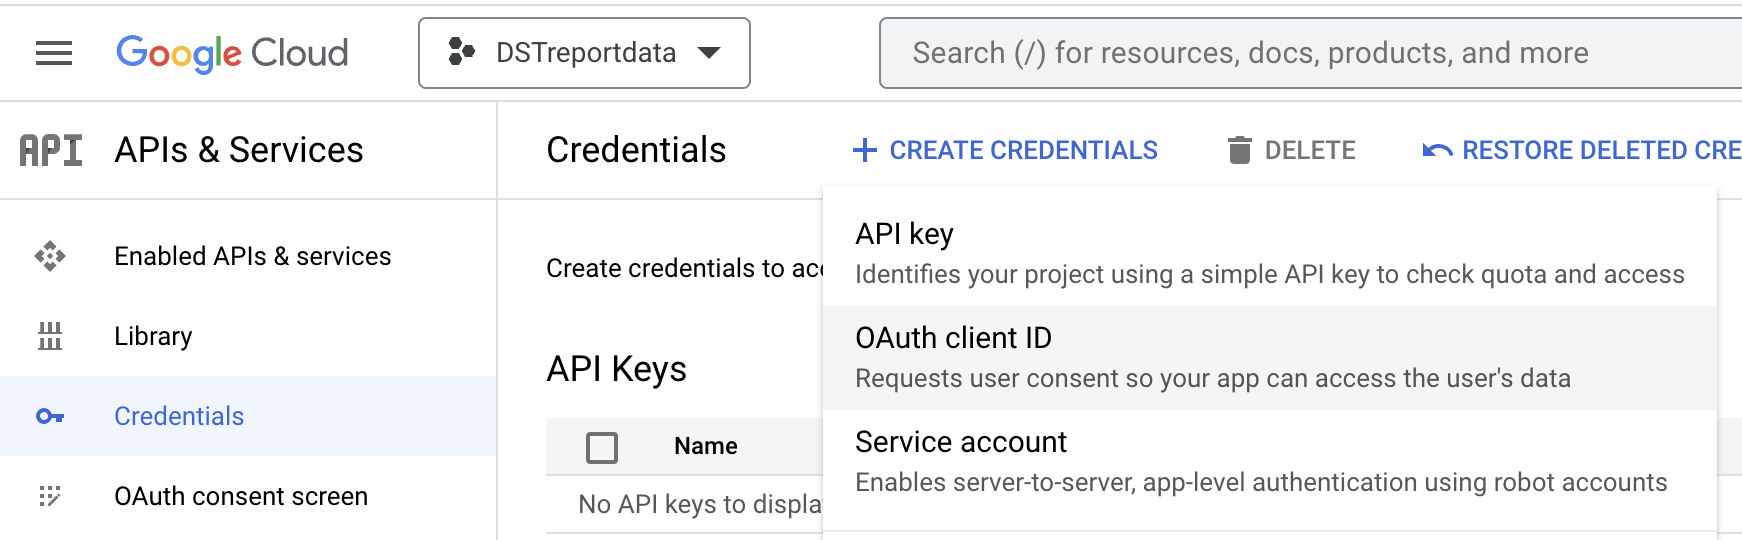

จากนั้นก็เลือกตามนี้ได้เลยแล้วกด Create
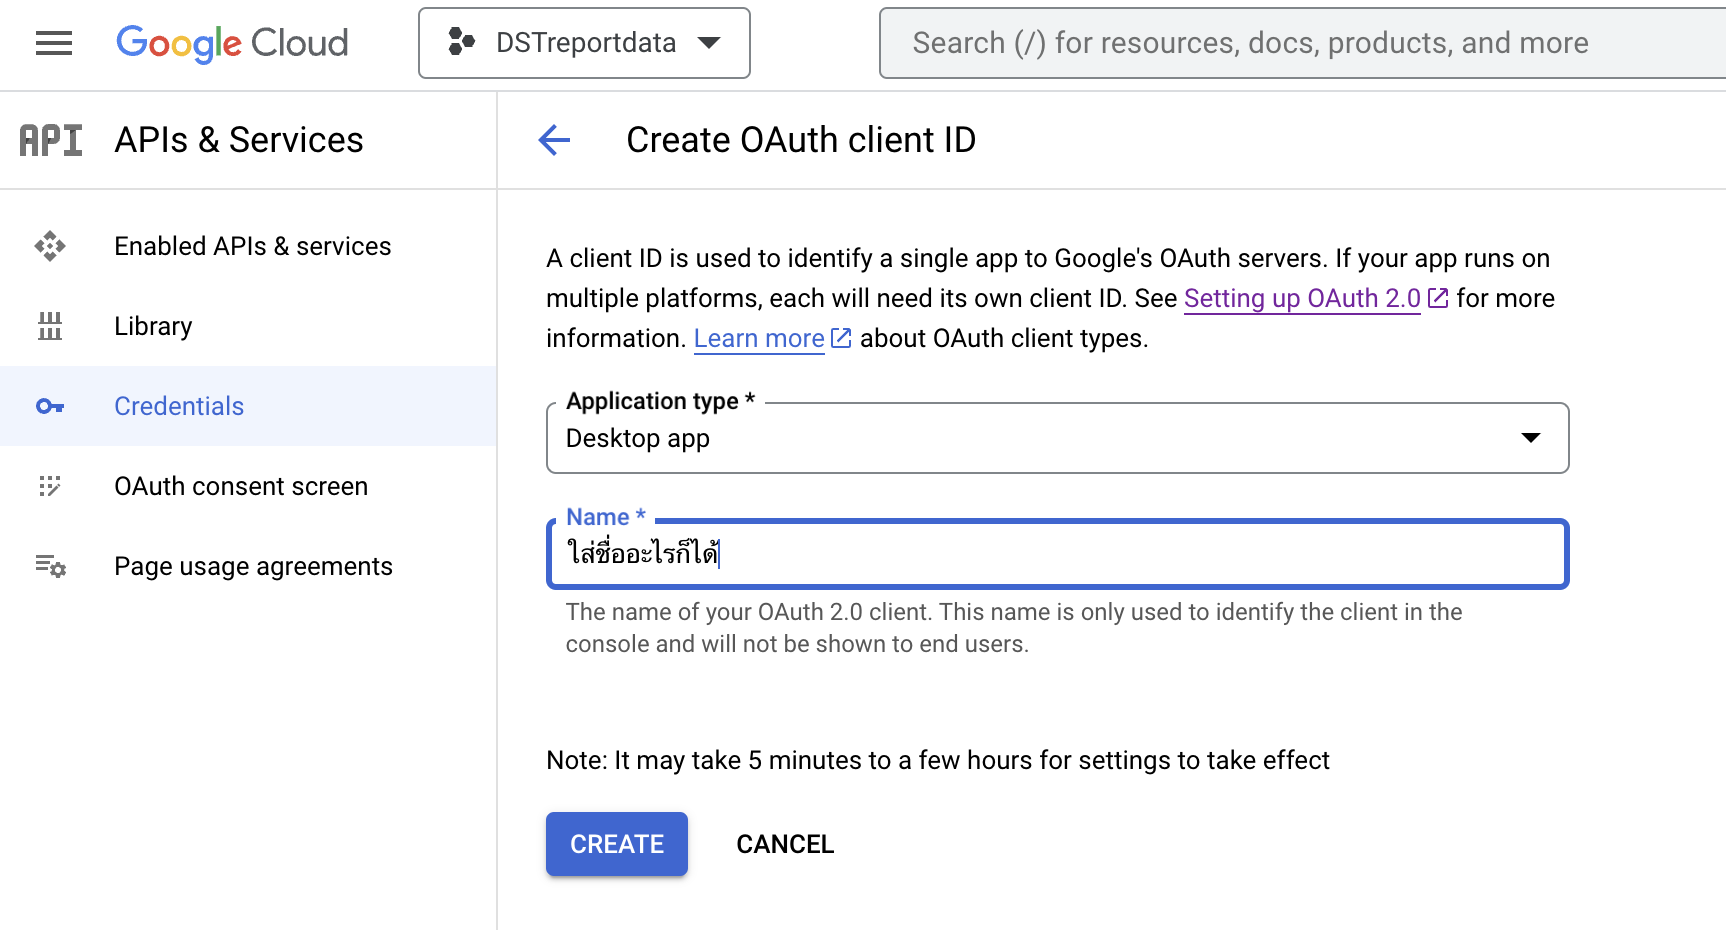

กลับมาที่หน้า Credentials เราก็จะเจอกับ Credential  ที่เราพึ่งสร้างไว้ ให้จิ้มที่ปุ่ม Download ด้านซ้าย

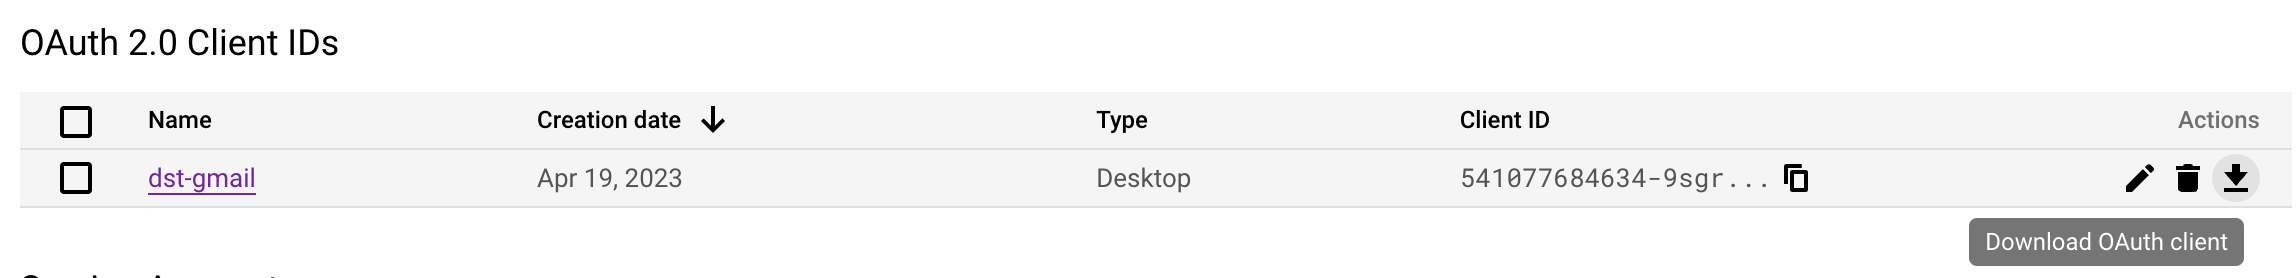

เราก็จะได้ไฟล์ json ที่บรรจุความลับมาหนึ่งไฟล์ ให้เอามาวางไว้ใน project ของเรา

ทดสอบว่า Sign-in ได้ไหมม?

In [ ]:
# import package ที่จำเป็นก่อน 
import os.path
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import base64

กำหนด Scope ให้กับ script ของเราว่าเราจะใช้ API เพื่ออ่านเท่านั้น

In [ ]:
# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']


### Sign in with gmail account and get attachment

ถ้าเรา Run code ด้านล่างรอบแรก เราจะได้ Sign in google account ของเรา ก็จัดการ login ด้วย Gmail ที่เราสมัครใหม่ ไปซะ! 

หลังจากนั้น code ก็จะทำการ มองหา Email ฉบับล่าสุดในกล่องจดหมายแล้วทำการ download attachment มาเก็บไว้ก่อน

In [ ]:
def get_attachment():
    """
    Sign in with Gmail ang get the attachment from lasted email that forwarded from Opera system.
    """
    creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first time.
    if os.path.exists('credentials/token.json'):
        creds = Credentials.from_authorized_user_file('credentials/token.json', SCOPES)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials/credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run.
        with open('credentials/token.json', 'w') as token:
            token.write(creds.to_json())


    try:
        # Call the Gmail API.
        service = build('gmail', 'v1', credentials=creds)
        # Looking for the lastest email and get the message ID.
        get_first_mail = service.users().messages().list(userId='me', maxResults=1).execute()
        message = get_first_mail.get('messages', [])[0]
        # Read the messange body and get attachment ID.
        msg = service.users().messages().get(userId='me', id=message['id']).execute()
        get_attachmentid = msg['payload']['parts'][1]['body']['attachmentId']
        # Get attachment file, save then upload to GCS.
        data = service.users().messages().attachments().get(userId='me', messageId=message['id'], id=get_attachmentid).execute()
        # Decode base64 in a file.
        text_to_write = str(base64.b64decode(data['data']))
        return text_to_write
    

    except HttpError as error:
        # TODO(developer) - Handle errors from gmail API.
        print(f'An error occurred: {error}')


ถ้าเกิดเจอหน้านี้ไม่ต้องตกใจ เพราะว่าเราเป็นผู้พัฒนาเถื่อน app ของเรายังไม่ได้ verify จาก google ก็ให้กด Advance แล้วกด continue เพื่อไปต่ออ

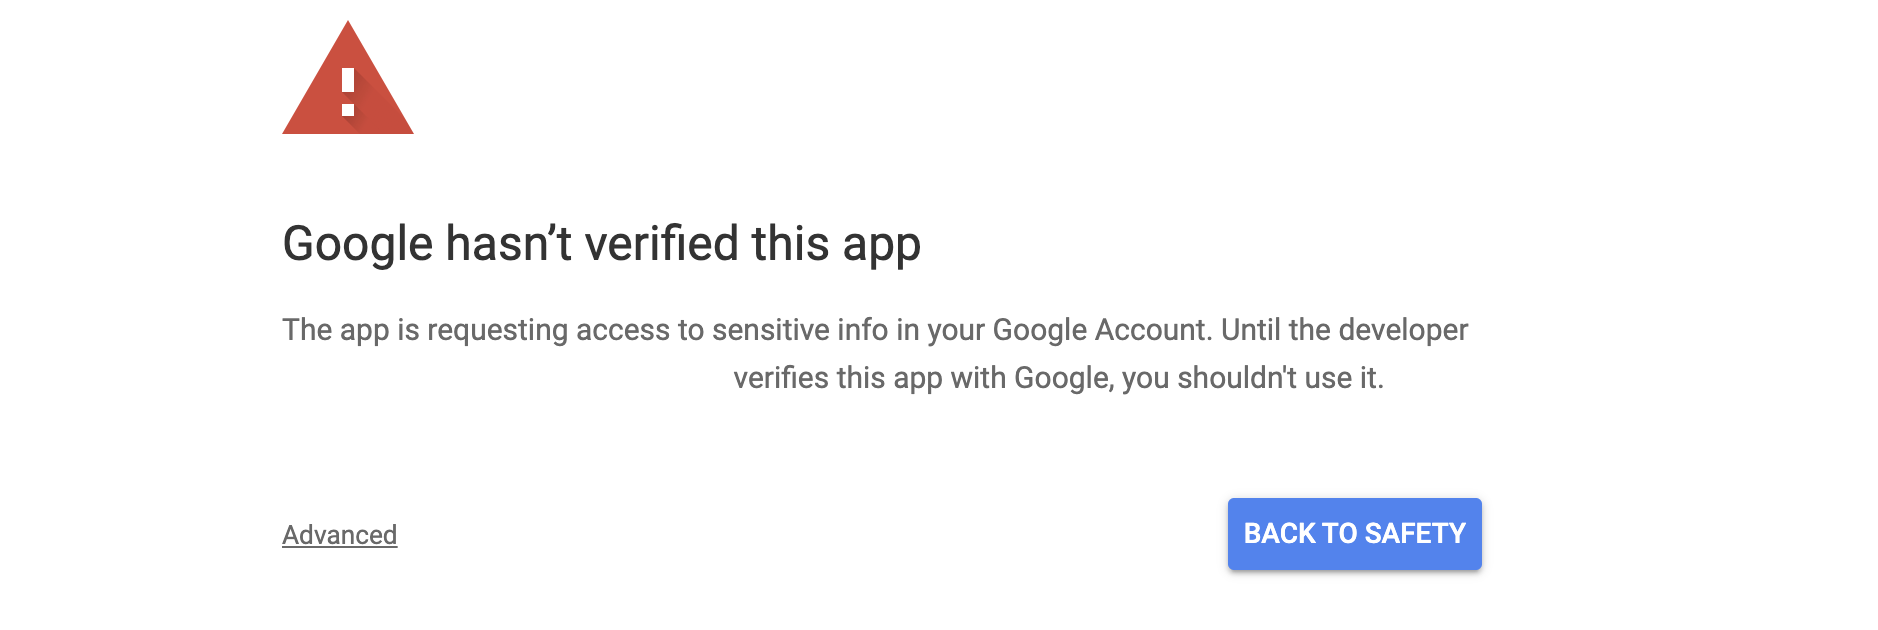

## 3. Data Cleansing

### Write attachment to a file

เขียนไฟล์เก็บไว้ก่อนเดี๋ยวเอาไป Clean ต่อเนื่องจากไฟล์มัน format ด้วยการเอาชื่อ colum ขึ้นก่อนทุกแถวเลย ก็จัดการ replace เพื่อให้ตอน import แล้วสบายตาหน่อย

In [ ]:
with open("raw_data.csv", "w") as f:
  formatted_output = get_attachment().replace("b'", '').replace('\\n', '\n').replace('\\t', '\t').replace('Date|Time|Room No.|Name|Trn. Code|Description|Check No.|Currency|Debit|Credit|Cash ID|User Name|Supplement/Reference/Credit Card No.|Exp. Date|Receipt No.|', '').replace("'", "")
  f.write('Date|Time|Room_No|Name|transaction_code|Description|Check_No|Currency|Debit|Credit|Cash_ID|User_Name|Supplement/Reference/Credit_Card_No|Exp_Date|Receipt_No|\n')
  f.write(formatted_output)

### Import to DataFrame & Exploring Data

In [ ]:
import pandas as pd

df = pd.read_csv("raw_data.csv", delimiter="|", index_col=False)

จัดการ drop col ที่ไม่ได้ใช้ซะแล้วก็ Check data format นิดนึง


In [ ]:
df = df.drop(columns=['Check_No', 
                      'Time',
                      'Cash_ID', 
                      'User_Name', 
                      'Supplement/Reference/Credit_Card_No', 
                      'Exp_Date', 
                      'Receipt_No', 
                      'Unnamed: 15',
                      ])
df.dtypes

Date                 object
Room_No               int64
Name                 object
transaction_code      int64
Description          object
Currency             object
Debit                object
Credit              float64
dtype: object

สิ่งทีต้องจัดการคือ format Date และ Time
จัดชื่อสวยๆ ให้อ่านง่าย
เปลี่ยน ช่อง debit เป็น float
ส่วนข้อมูลอื่นๆ ทำให้เป็น string ให้หมด เริ่ม!!

### Format Date

In [ ]:
df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%d/%m/%y')


### Format Name

ใช้ Method `str.split` กับคอลัม `Name` แยกชื่อ สกุล และคำนำหน้าออกจากกันแล้วสร้าง columns ใหม่มาเก็บไว้

จากนั้นก็ เอามารวมกันใน `new_name` ต่อไปก็ drop ของเดิมทิ้งแล้วเปลี่ยนชื่อใหม่ให้เหมือนเดิมเนื่องจากเห็นแว๊บๆ ว่าชื่อมีตัวอักษรแปลกๆติดมาด้วยเลยทำการเขียน regex เพื่อ remove ตัวอักษรที่ไม่ต้องการออกไปจาก column `Name`

In [ ]:
# Split the "original_name" column into separate "last name", "first name", and "title" columns
df[['last name', 'first name', 'title']] = df['Name'].str.split(',', expand=True)

# Concatenate the columns in the desired format
df['new_name'] = df['title'].str.strip() + ' ' + df['first name'].str.strip() + ' ' + df['last name'].str.strip()
# Drop columns. 
df.drop(['last name', 'first name', 'title', 'Name'], axis=1, inplace=True)
# Replace the "new_name" column with the "Name" column
df.rename(columns={'new_name': 'Name'}, inplace=True)
#
df['Name'] = df['Name'].replace(r'[^a-zA-Z\s.]', '', regex=True).astype(str)
df.dtypes

Date                datetime64[ns]
Room_No                      int64
transaction_code             int64
Description                 object
Currency                    object
Debit                       object
Credit                     float64
Name                        object
dtype: object

### format Number

เนื่องจาก ช่อง Debit เรายังเป็น object. และข้อมูลตัวเลขในนี้ก็ถูกแบ่งด้วย `","` และจำนวนที่ติดลบก็มีการเว้นวรรคระหว่างเครื่องหมาย `"-"`
เราจึงต้องเอาคอมม่าและเว้นวรคคออกก่อนแล้วแปลงเป็น float อีกทีนึงง

In [ ]:
df['Debit'] = df['Debit'].str.replace(',', '').str.replace(' ', '')
df['Debit'] = df['Debit'].astype(float)
df.loc[df['Debit'] < 0, 'Credit'] = -1 * df['Debit']
df.loc[df['Debit'] < 0, 'Debit'] = 0.0
df.dtypes

Date                datetime64[ns]
Room_No                      int64
transaction_code             int64
Description                 object
Currency                    object
Debit                      float64
Credit                     float64
Name                        object
dtype: object

จากนั้นก็ย้ายค่าที่ติดลบไปช่อง `Credit` ซะเพื่อให้ถูกต้องตามหลักบัญชีที่ควรจะเป็น

### Convert remain Datatype to string.

อันไหนที่ยังไม่เป็น String ก็จับทำเป็น String ซะ เป็นอันจบพิธี

In [ ]:
df['Description'] = df['Description'].astype('string')
df['Currency'] = df['Currency'].astype('string')
df['Name'] = df['Name'].astype('string')
df.dtypes


Date                datetime64[ns]
Room_No                      int64
transaction_code             int64
Description                 string
Currency                    string
Debit                      float64
Credit                     float64
Name                        string
dtype: object

ที่ยังเก็บ column name ไว้เพราะว่ายังใช้เป็น Reference ในการทำเบิก comission เมื่อก่อนใช้ cashier number แต่พอระบบ pos เปลี่ยน เลขตรงนี้เลยเหมือนกันทุก transaction ทำให้ระบุผู้ที่ทำการ up-sale ไม่ได้

เขียนลงไฟล์ csv เพื่อเตรียมอัพโหลด่อไป 


In [ ]:
from datetime import date

# Get date, year data
today = date.today()
year = str(today.year)
# Setup file name from upload date
filename = (f"{today}_dst_revenue.csv")

# Write to csv
df.to_csv(
    path_or_buf=filename,
    index=False,
)

In [ ]:
# แอบดูหน้าตา dataframe หน่อยย
df

,Date,Room_No,transaction_code,Description,Currency,Debit,Credit,Name
0,2023-01-01,2,3431,Photography & Videography,THB,47000.0,0.00,Mr. Siraphatch Sopaspinyophong
1,2023-01-01,61,3431,Photography & Videography,THB,9000.0,0.00,Mr. Robert Reibestein
2,2023-01-01,61,3950,Photography Disc,THB,0.0,2999.70,Mr. Robert Reibestein
3,2023-01-01,46,3431,Photography & Videography,THB,1500.0,0.00,Mr. Kaan Tolga Gunay
4,2023-01-01,46,3950,Photography Disc,THB,0.0,225.57,Mr. Kaan Tolga Gunay
5,2023-01-08,42,3431,Photography & Videography,THB,5000.0,0.00,Ms. Karinrat Srisamith
6,2023-01-08,10,3431,Photography & Videography,THB,5000.0,0.00,Mr. Ricardo Cholbi Tepedino
7,2023-01-20,6,3431,Photography & Videography,THB,5000.0,0.00,Mrs. Cecilia Garcia Lavor
8,2023-01-23,50,3431,Photography & Videography,THB,5000.0,0.00,Mr. Tanasak Vaiphasa
9,2023-01-25,16,3431,Photography & Videography,THB,1500.0,0.00,Mr. Lihua Zhang


## 4. Upload to GCS

### Create Service Account


ในการ Access เพื่อ Read/Write ใน bucket ของ GSC เราจะต้องสร้าง Service Account ขึ้นมาและเอา credential ของ account นั้นมาเรียกใช้

ไปที่ IAM & Admin แล้วมองหาหัวข้อ Service Account

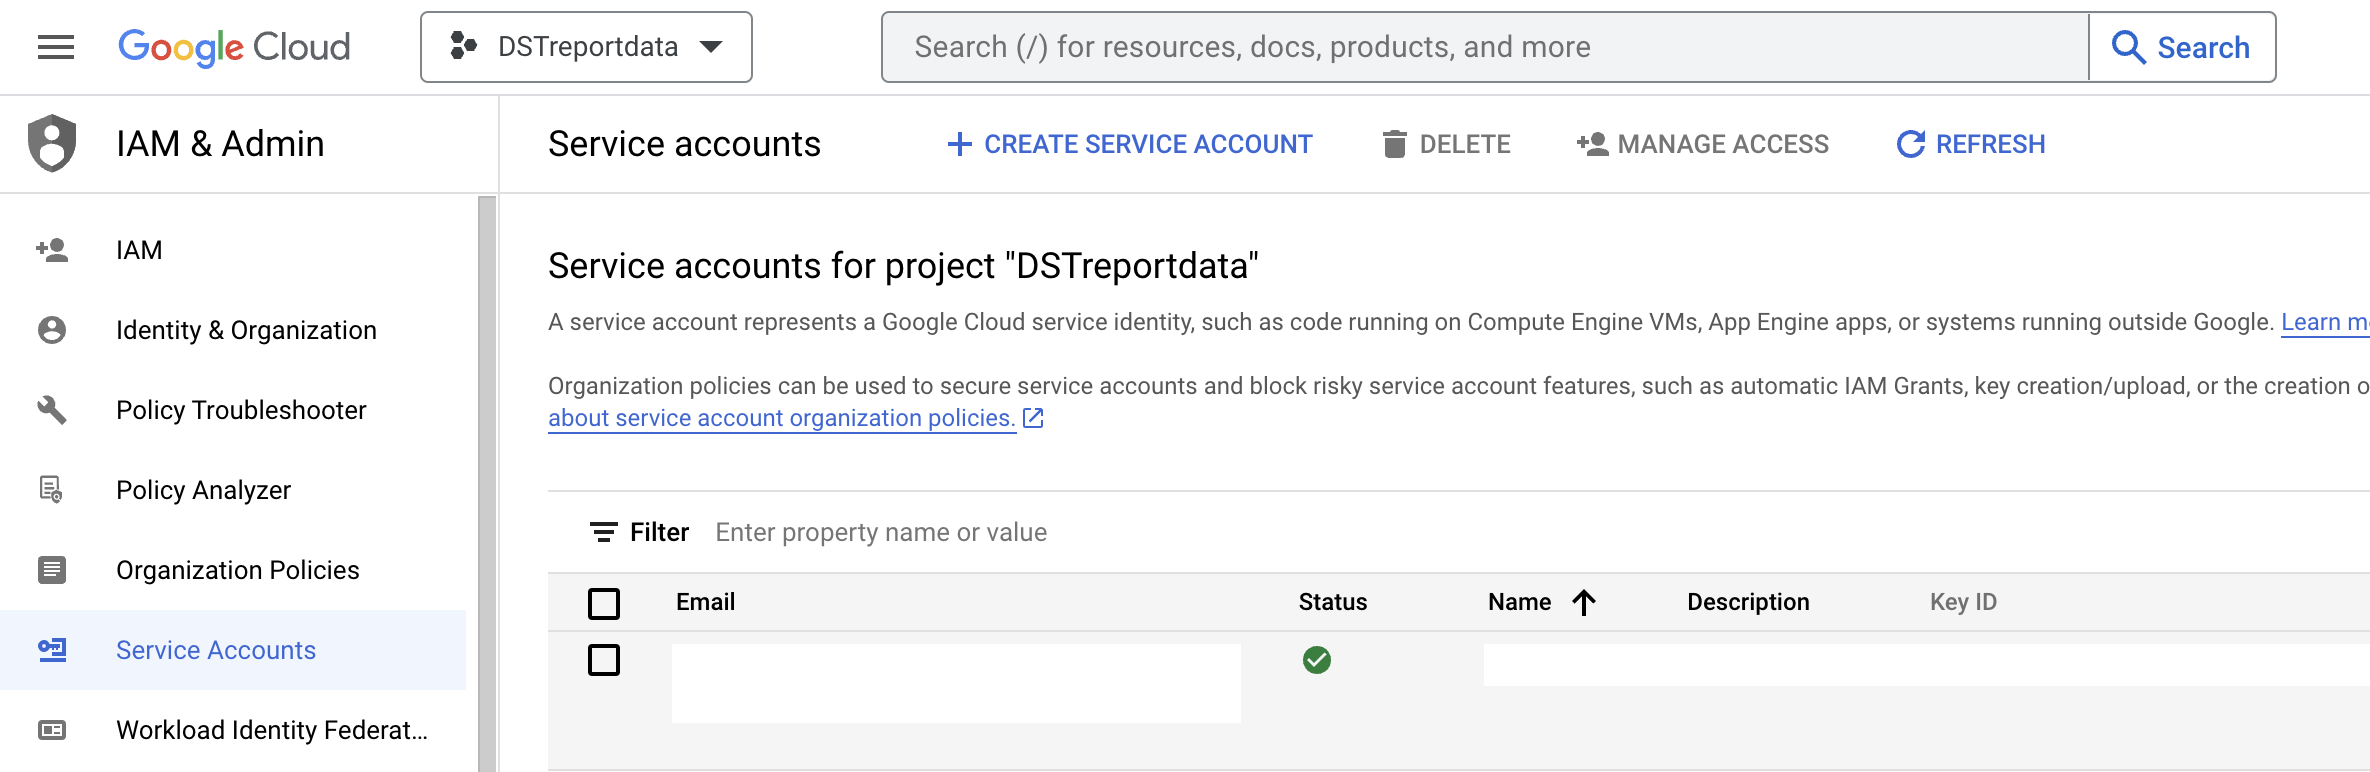

จากนั้นกด Create Service Account ได้เลย

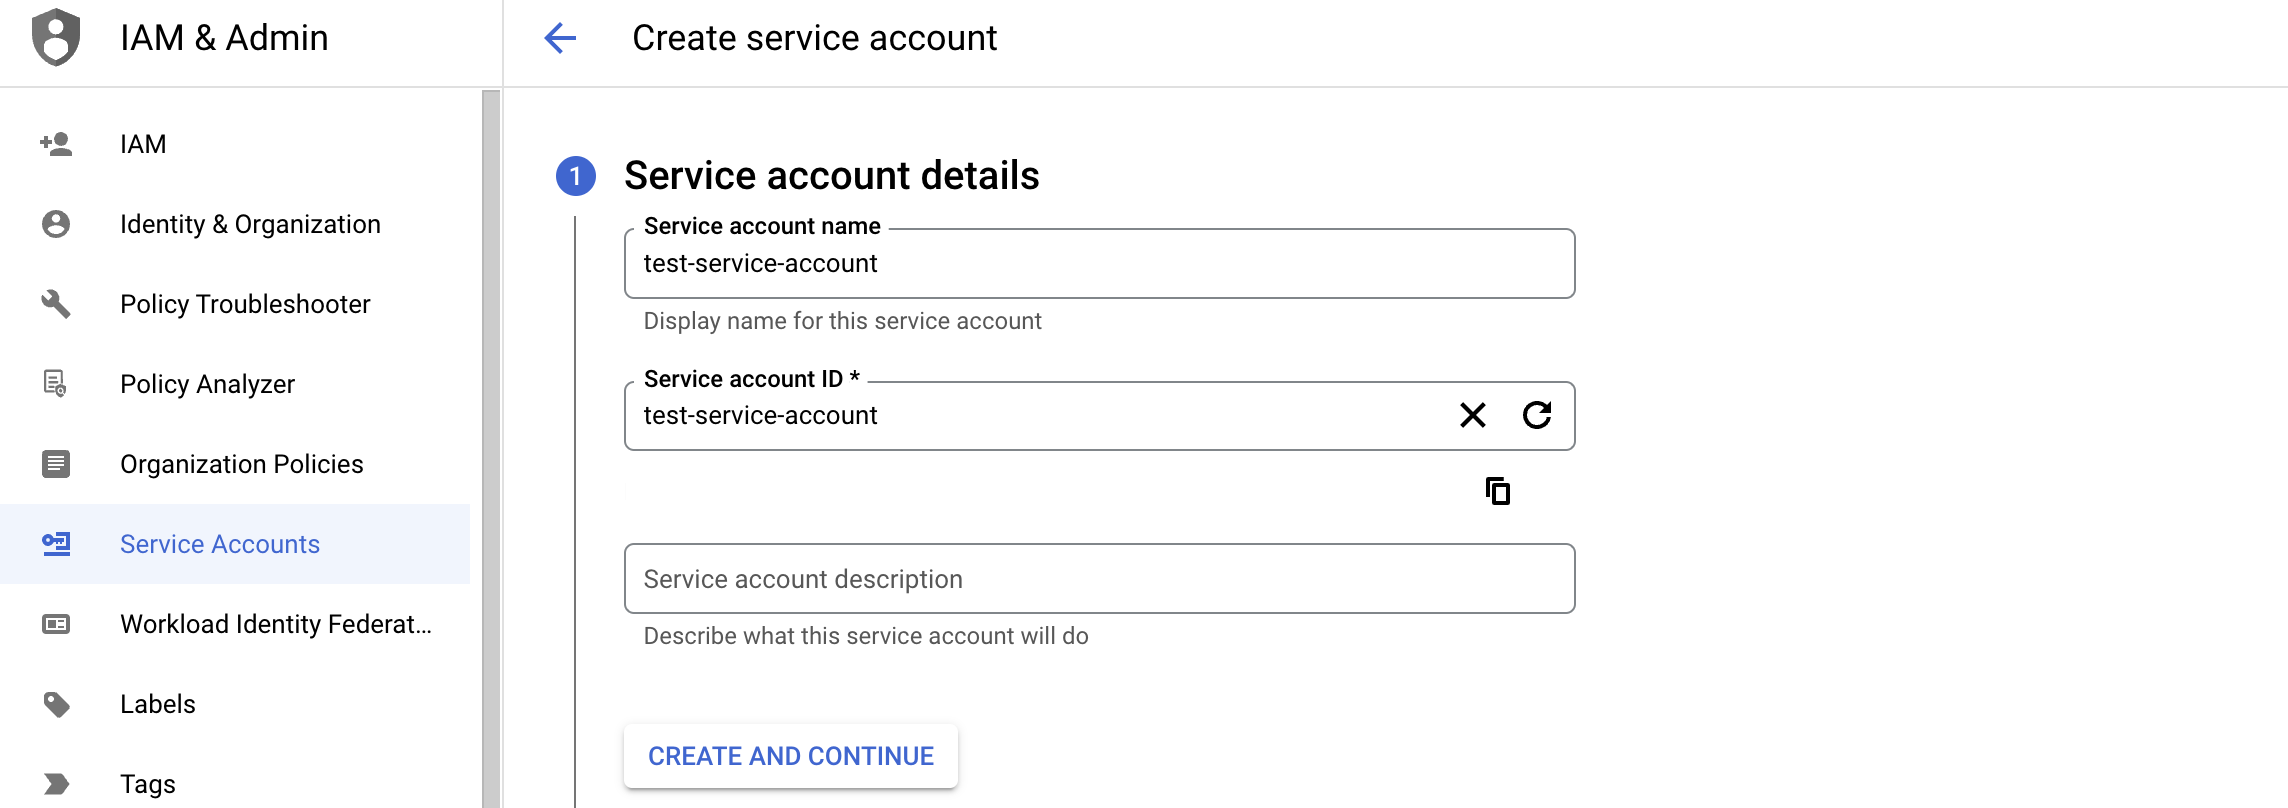

จะใส่ชื่ออะไรก็ได้แล้วแต่เรา จากนั้นกด Create And Continue

ให้ role เป็น editer เพื่อที่จะอ่านและแก้ไขไฟล์บน GCS ได้จากนั้นกด continue
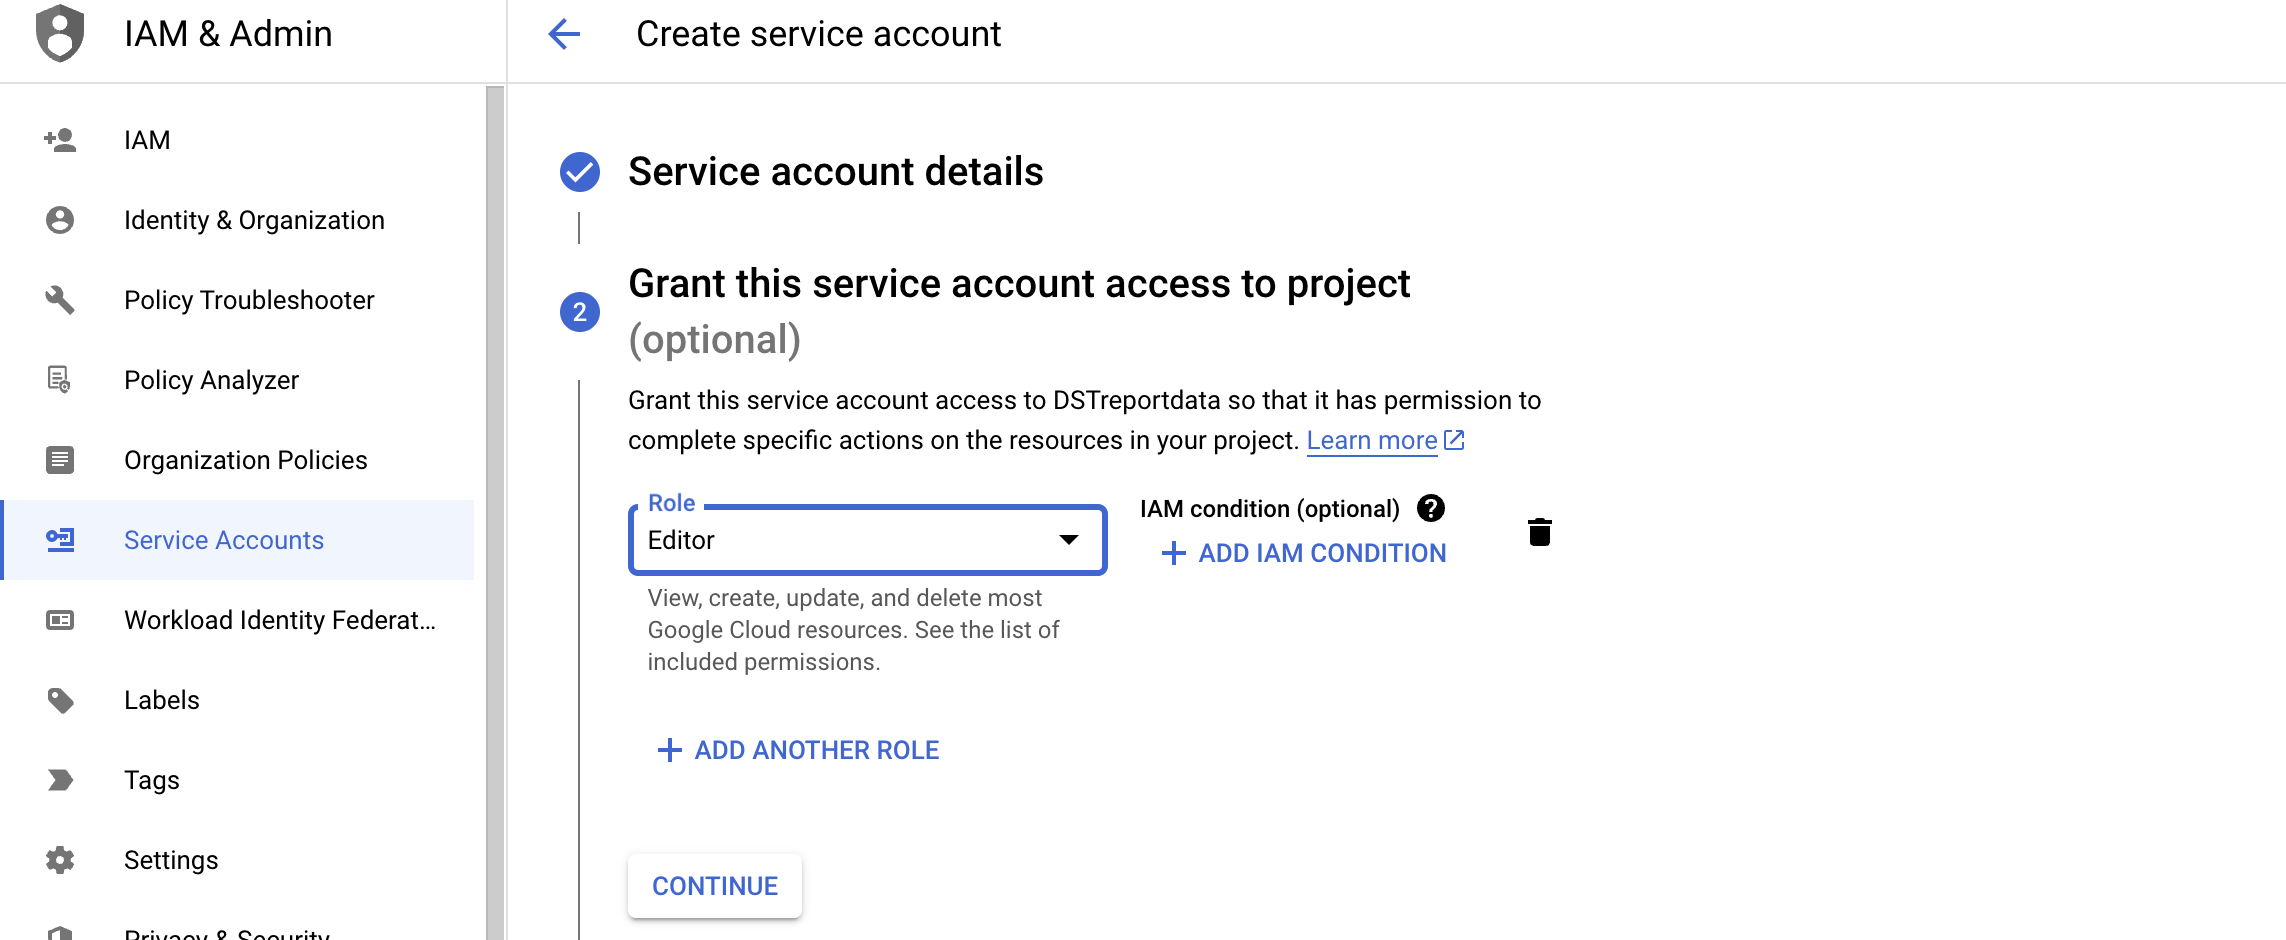

จากนั้นกด continue แล้วก็ ok ได้เลยเราจะกลับไปหน้า Service Account ก็จะเจอกับชื่อที่เราพึ่งสร้าง จากนั้นเราก็จิ้มที่ชื่อนั้นซะหนึ่งที

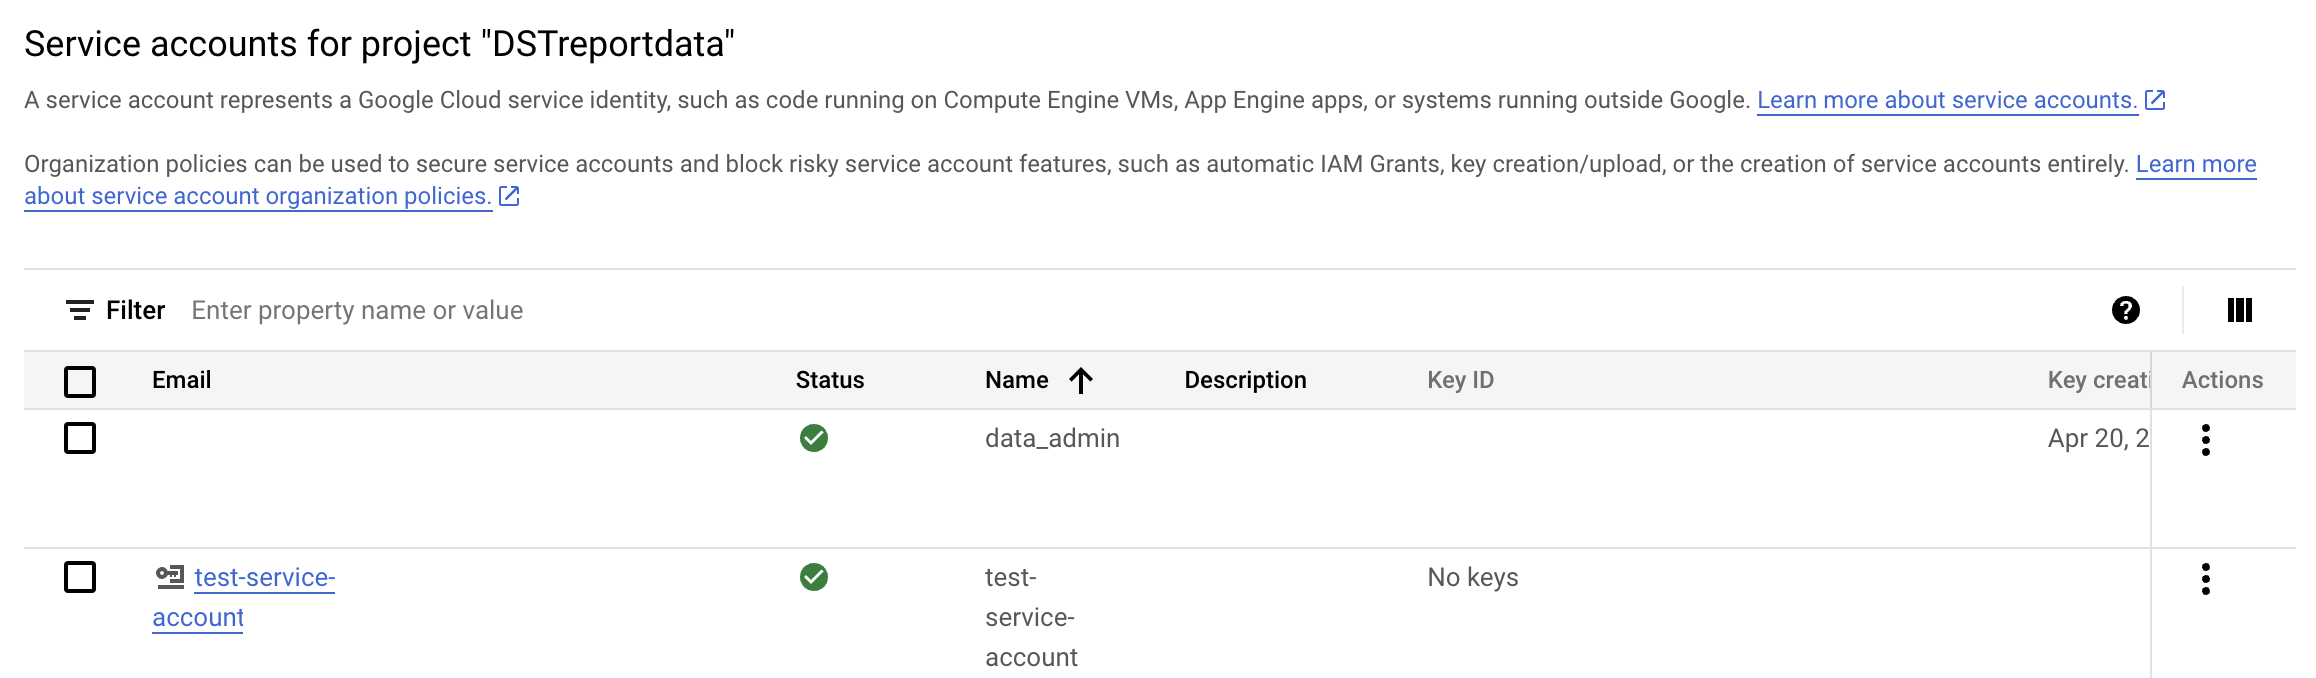

เข้าไปที่ tab KEYS แล้วกด ADD KEY > CREATE NEW KEY

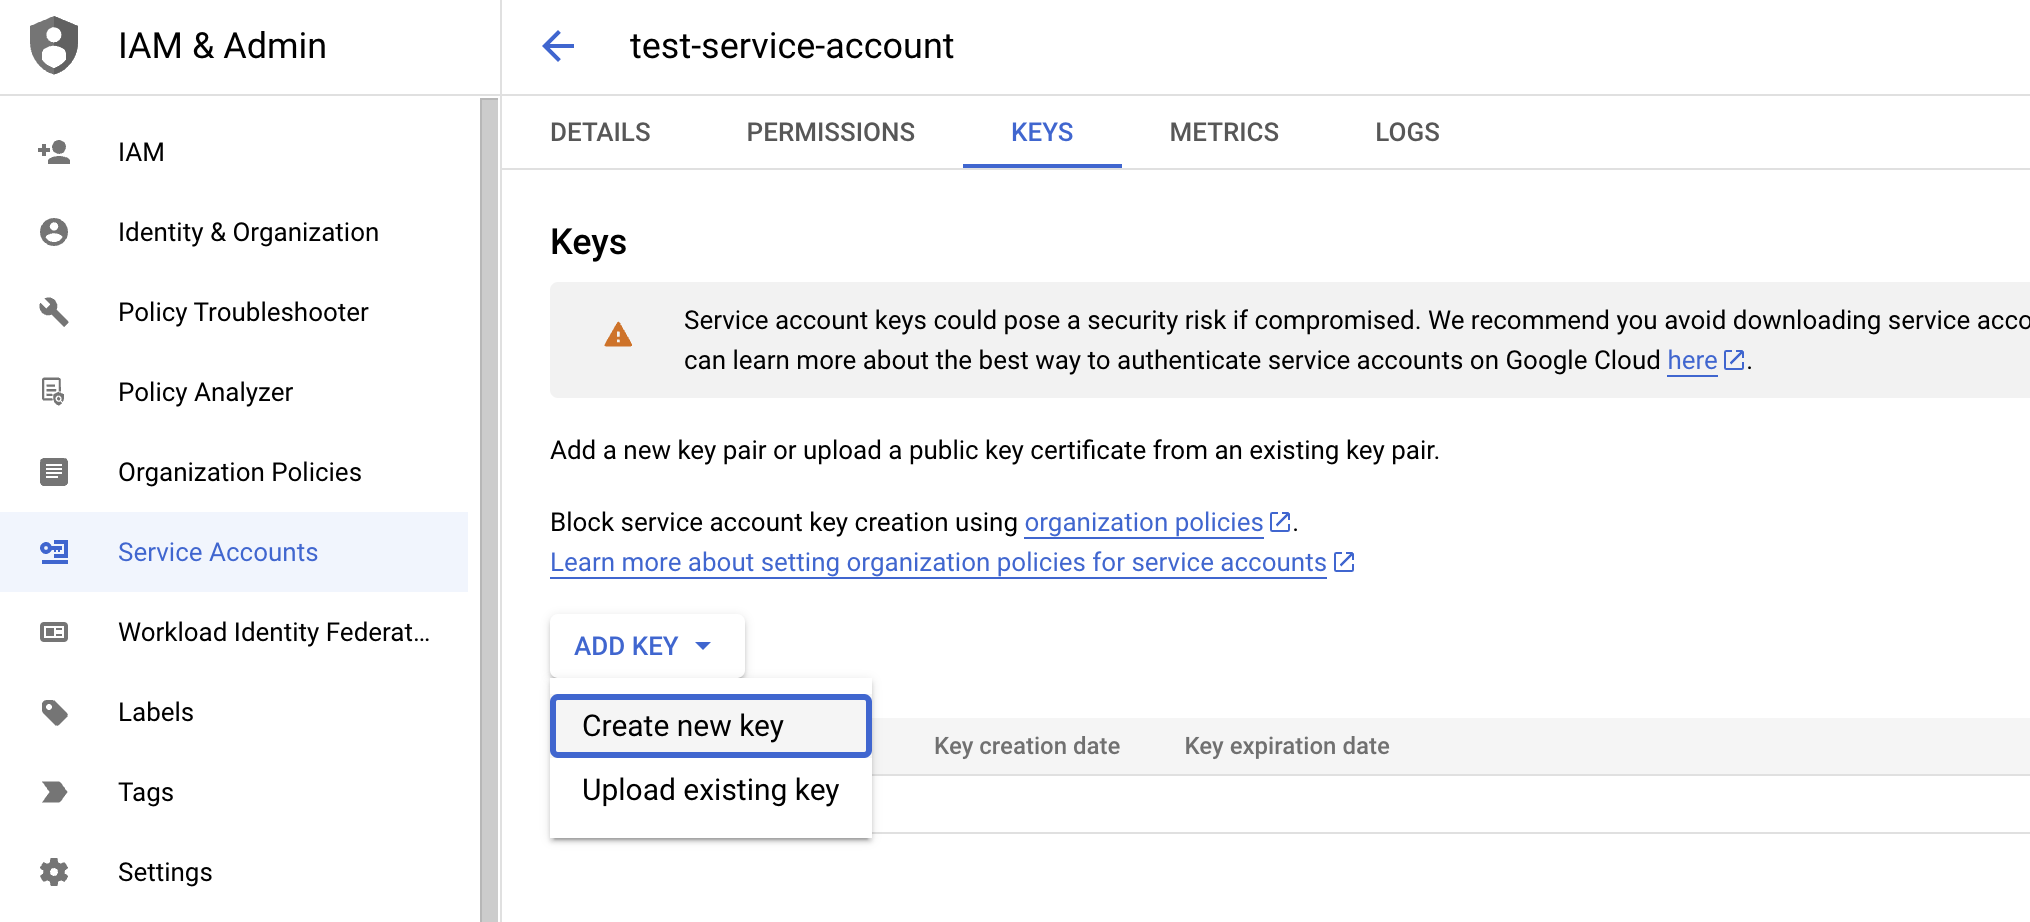

แล้วก็จะมี pop-up ขึ้นมาให้เราเลือก json แล้วกด Create
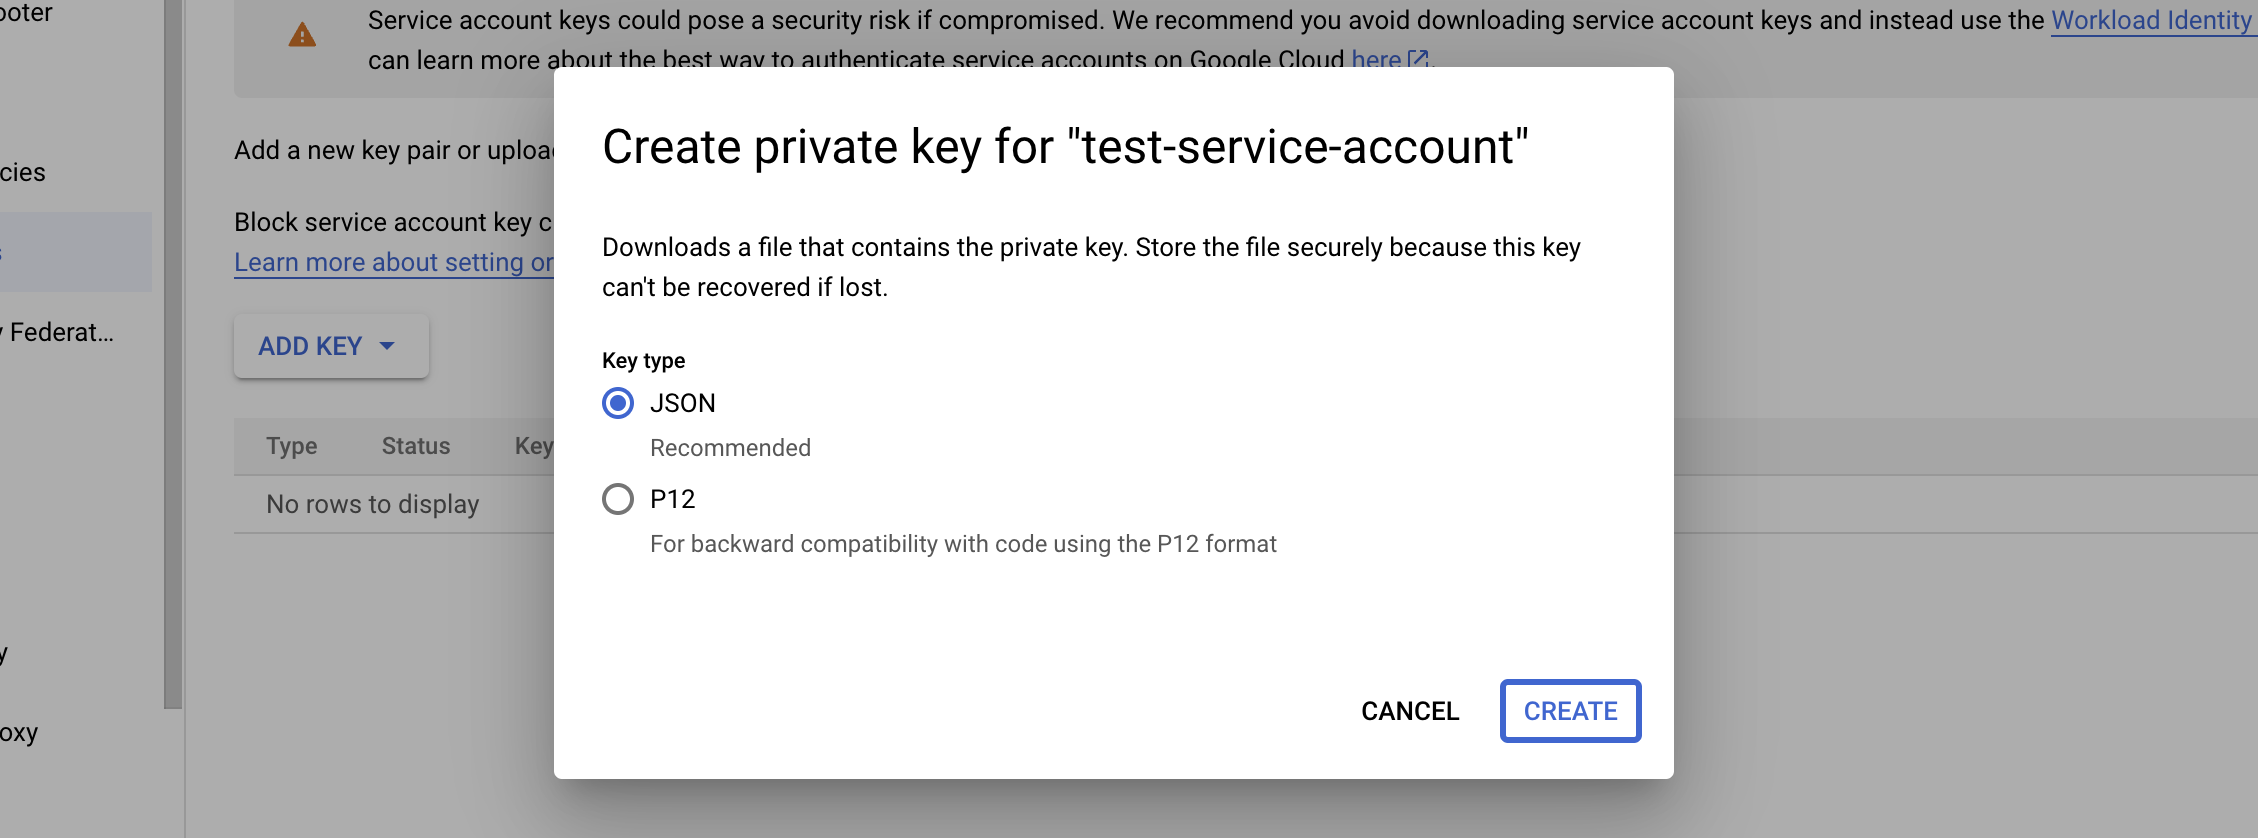

เราก็จะได้ file.json มาไฟล์นึงอันนี้จะเป็นไฟล์ที่เราจะใช้เปิดประตูเข้า Google Cloud Product 

### Grant Access to Service Account

***  กาดอกจันหน่อย เราต้องไปให้ Access กับ Service Account ที่เราพึ่งสร้างให้สามารถเข้าถึง bucket นั้นๆ ได้ เพราะตัวผู้เขียนเองติดอยู่ตรงนี้ชั่วโมงว่าทำไมเขียนไฟล์ลง GCS ไม่ได้ทั้งๆ เข้าไปด้วย Role Editor ที่มี permission สร้าง เขียน ลบ บน GCP ได้ ***

เข้าไปที่ Cloud Storage เลือก Bucket ที่เราต้องการจะให้ Access กับ Service Account แล้วมองขวา จิ้มตุ่มไข่ปลาสามดวง เลือก Edit access

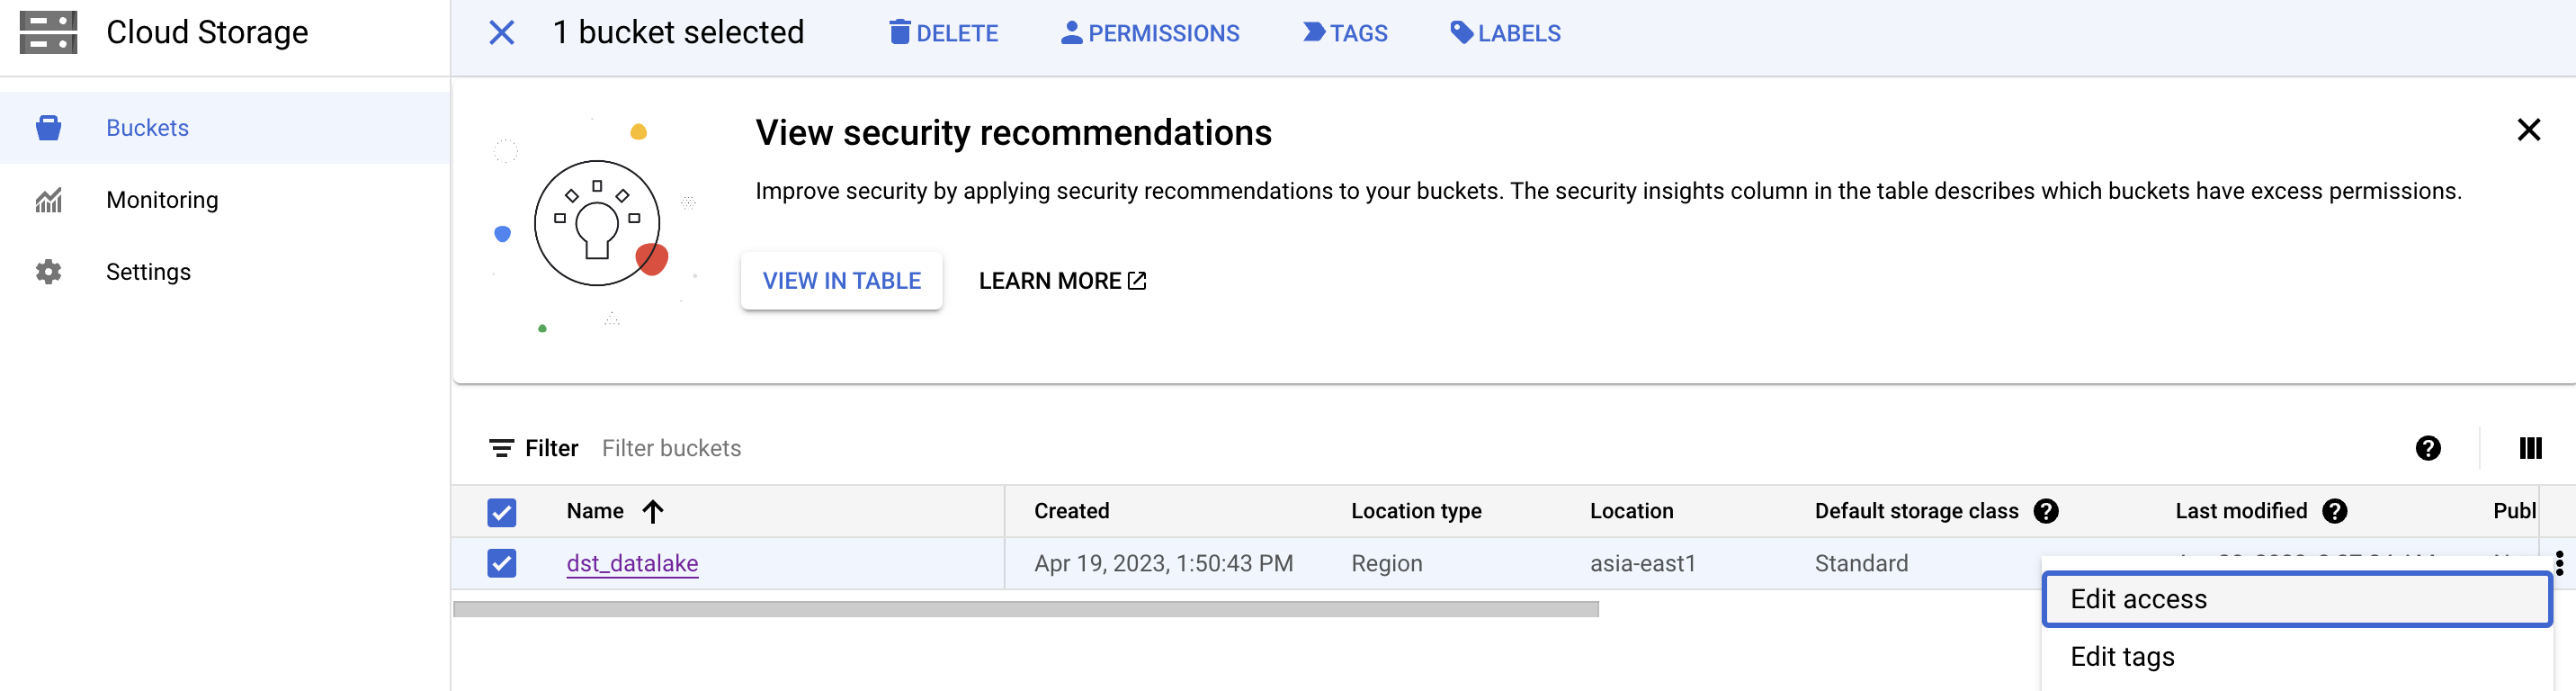

กด Add Principal จากนั้นให้ใส่ Email ของ Service Account ที่เราพึ่งสร้างไปในช่อง New Principal ถ้าจำไม่ได้ก็กลับไป Copy ใหม่มาจากหน้า IAM & Admin > Service Account

ส่วนในช่อง Select role ให้เลือก Storage Object Creator หรือ Storage Object Admin

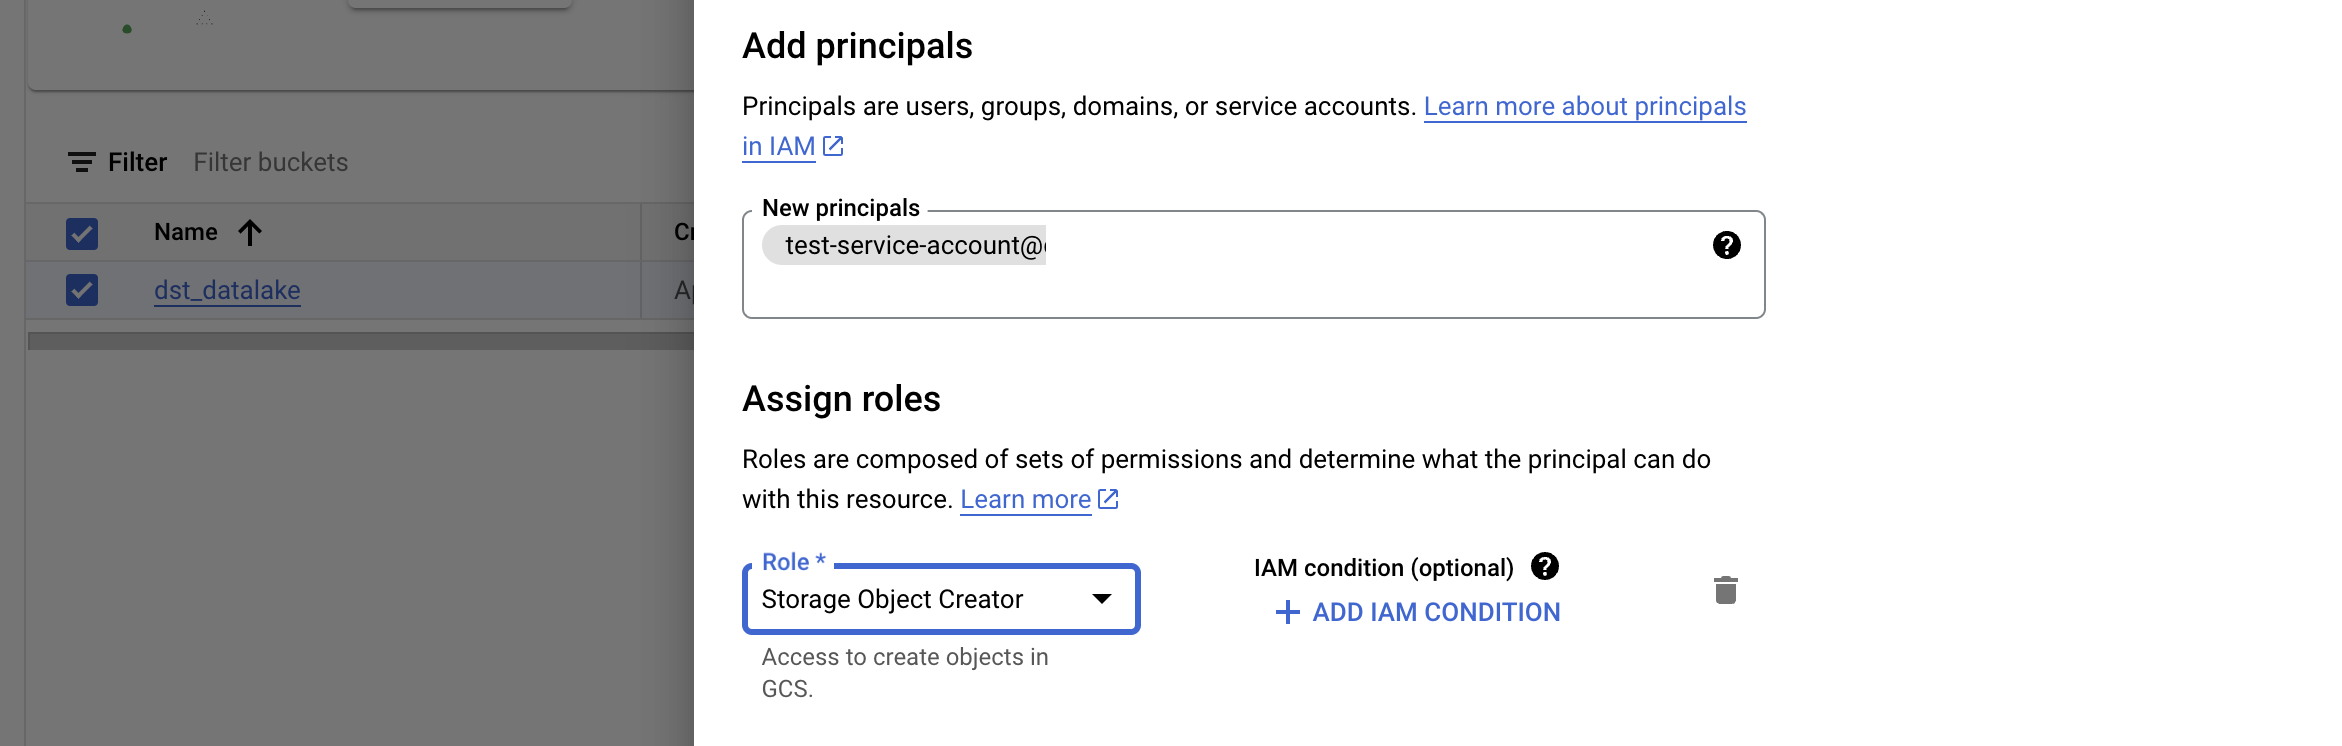

เขียนข้อมูลลง GCS จาก data ที่โหลดมาจาก Email Attachment โดย path file จะตามปีที่ทำการ Upload 

### Upload to GCS

In [ ]:
from google.cloud import storage

# Credential for GCP.
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "credentials/dstreportdata-48acf2cbeed0.json"
# File name by generated date.

# Write a file to GCS without saving it to the local.
def write_to_blob():
    # Get client credentials to connect with GCS.
    client = storage.Client()
    # Select bucket to upload file.
    bucket = storage.Bucket(client, 'dst_datalake')
    # Create blob with file path to upload.
    blob = bucket.blob(f"report_data/{year}/{filename}")
    # Upload from file name.
    blob.upload_from_filename(filename)


write_to_blob()

เขียน code เช็คหน่อยว่าไฟล์ถูก upload ไปถูกที่ไหม

In [ ]:
def check_file_upload():
  client = storage.Client()
  blobs = list(client.list_blobs(bucket_or_name="dst_datalake", prefix="report_data/2023"))
  for blob in blobs:
    if not blob.name.endswith('/'):
      if filename in blob.name:
        print(blob.name)

check_file_upload()


report_data/2023/2023-01-31_dst_revenue.csv


## 5. Download From GCS and generate Report

### Get file list to download

เราจะต้อง Download ทั้งหมด 3 ไฟล์ก็ list file ใน Bucket ออกมาก่อน แล้วก็ slice เดือนของไฟล์นั้นๆ ออกมาหาว่าอยู่ในไตรมาศที่เราต้องการหรือไม่


In [18]:
# เนื่องจากตอนที่เขียน colab ตอนนี้ อยู่ในช่วงเดือน 4 เราจะรันย้อนหลังไป 1q ปกติจะใช้ quarter = (today.month - 1) // 3 + 1
previous_quarter = (today.month - 1) // 3

def get_file_list(year, quarter):
    client = storage.Client()
    blobs = list(client.list_blobs(bucket_or_name="dst_datalake", prefix=f"report_data/{year}"))
    q_list = []
    for blob in blobs:
        if not blob.name.endswith('/'):
            item_quarter = (int(blob.name[22:24]) - 1) // 3 + 1
            if item_quarter == quarter:
                q_list.append(blob.name)
    return q_list

### Download From GCS

In [19]:
# Initialise a client
storage_client = storage.Client()
# Create a bucket object for our bucket
bucket = storage_client.get_bucket("dst_datalake")

for item in get_file_list(year, previous_quarter):
    # Create a blob object from the filepath
    blob = bucket.blob(f"{item}")
    # Download the file to a destination
    blob.download_to_filename(f"{item[17:]}")

พอรันโค๊ดผ่าน เราก็จะได้ไฟล์มามาอยู่ในเครื่อง 3 ไฟล์ซึ่งเป็น file ของไตรมาศที่แล้ว ตามที่เราตั้งใจ

### Generate report

เริ่มด้วย Join csv file

In [46]:
import pandas as pd
import glob

# setting the path for joining multiple files
files = os.path.join("*dst_revenue.csv")

# list of merged files returned
files = glob.glob(files)

# joining files with concat and read_csv
df_report = pd.concat(map(pd.read_csv, files), ignore_index=True)
df_report = df_report.drop(columns=['Name'])
df_report.head()

,Date,Room_No,transaction_code,Description,Currency,Debit,Credit
0,2023-01-01,2,3431,Photography & Videography,THB,47000.0,0.00
1,2023-01-01,61,3431,Photography & Videography,THB,9000.0,0.00
2,2023-01-01,61,3950,Photography Disc,THB,0.0,2999.70
3,2023-01-01,46,3431,Photography & Videography,THB,1500.0,0.00
4,2023-01-01,46,3950,Photography Disc,THB,0.0,225.57


อธิบาย Package กับราคานิดนึง เพราะ POS ตอนนี้จิ้มได้แค่ราคา 

In [47]:
# Define function to map prices to packages
def get_package(price):
    if price == 1500:
        return 'Gopro rental'
    elif price == 5000:
        return 'Capture Moment Package'
    elif price == 0:
        return 'Photography Discount'
    elif price == 9000:
        return 'Moving memories package'
    elif price > 9000 and price <= 15000:
        return 'Rare Experience Package'
    elif price > 36000:
        return 'Your Soneva Journey Package'
    else:
        return 'Custom Package'

# Apply mapping function to "Debit" column to create new "Package" column
df_report['Package'] = df_report['Debit'].apply(get_package)

# Print resulting DataFrame
df_report.head()


,Date,Room_No,transaction_code,Description,Currency,Debit,Credit,Package
0,2023-01-01,2,3431,Photography & Videography,THB,47000.0,0.00,Your Soneva Journey Package
1,2023-01-01,61,3431,Photography & Videography,THB,9000.0,0.00,Moving memories package
2,2023-01-01,61,3950,Photography Disc,THB,0.0,2999.70,Photography Discount
3,2023-01-01,46,3431,Photography & Videography,THB,1500.0,0.00,Gopro rental
4,2023-01-01,46,3950,Photography Disc,THB,0.0,225.57,Photography Discount


ดู Summary แบบคร่าวๆ 

In [51]:
df_report.describe()

,Room_No,transaction_code,Debit,Credit
count,46.000000,46.000000,46.000000,46.000000
mean,32.543478,3498.695652,5956.521739,150.036522
std,20.686771,176.720856,8319.205415,617.601515
min,1.000000,3431.000000,0.000000,0.000000
25%,15.250000,3431.000000,2375.000000,0.000000
50%,42.000000,3431.000000,5000.000000,0.000000
75%,51.500000,3431.000000,5000.000000,0.000000
max,61.000000,3950.000000,47000.000000,2999.700000


### Add Summary to Dataframe and save to Excel

In [ ]:
# Save the dataframe to an Excel file
writer = pd.ExcelWriter(f'{year}_q{previous_quarter}_dst_report.xlsx')
df_report.to_excel(writer, index=False)
writer.save()

### Set up Apache Airflow with docker.

เราจะใช้ Airflow เพื่อ run task ดังต่อไปนี้

1. ทุกวันที่ 1 ของเดือนจะมี email report ของเดือนที่แล้วเข้ามาให้ download attachment แล้วทำการคลีนแล้ว upload ขึ้น GCS

2. เมื่อสิ้นไตรมาศให้ สร้างรีพอตสรุปรายไตรมาศ

Note** สมมุติเราตั้งให้ ทำงานทุกๆ วันที่สิ้นไตรมาศ แสดงว่าวันปีใหม่เราจะปีปัญหาเกี่ยวกับวันที่แน่นอน
ดังนั้นเราต้องตั้งให้ run code ตอนก่อนสิ้นวัน (หลัง 2 ทุ่มเพราะเป็นเวลาปิดบิลของรอบเช้า) 
